In [ ]:
"""
Economist Application Pt. 1 -- Cameron Ferwerda

Your script should output two CSVs, called polls.csv and trends.csv (for the averages). The polls file should have columns for 
date, pollster, n (sample size), and each candidate (by name); the trends file just date and a column for each candidate. Values 
for polls and trends should be a number from 0 to 1. The polls file should have a row for each poll. The trends file should 
have a row for each day, starting with October 11th, 2023.

Ideally it will have tests or some sort of error monitoring, and will detect or alert us in the event of a major error. 
(Writing errors to a log file is a sufficient alert for this assignment.) Your entire program should be executable from 
a single command, but it probably shouldn’t be written in a single monolithic script.
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.patches
import bambi as bmb
import arviz as az
import logging
import datetime as dt
from econ_app_utils import etl_data, fit_splines, plot_predictions, export_trend

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

sunlight_cat = ["#156B90", "#9a3e25", "#708259","#bd8f22" ,"#842854","#ba5f06","#0f8c79","#bd2d28","#A0B700","#f2da57","#8e6c8a","#7abfcc", "#f3a126"]

sns.color_palette(sunlight_cat)

dict_rc = {"grid.color": "#efecea", 'axes.facecolor':"#efecea", 'figure.facecolor':"#efecea", 'axes.edgecolor': "#635F5D",

               'axes.labelcolor': "#635F5D", 'text.color': '#635F5D','xtick.color': '#635F5D','ytick.color': '#635F5D'}; # "grid.color": "#635F5D",

sns.set_theme(context='notebook', palette = sunlight_cat, rc = dict_rc)

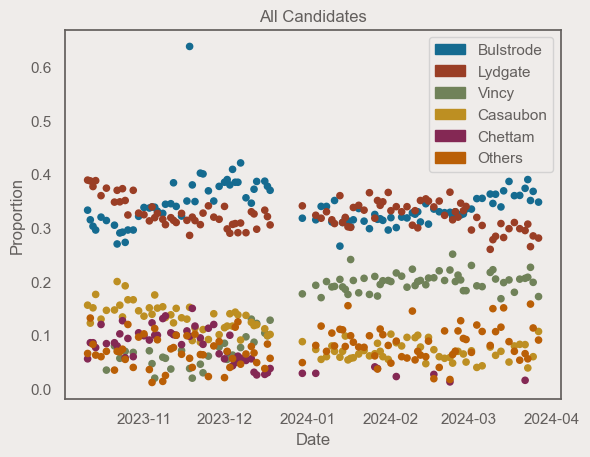

In [3]:
df_list, df_resample = etl_data('https://cdn-dev.economistdatateam.com/jobs/pds/code-test/index.html')

In [ ]:
#try:
#    df_cand = df_cand.astype(float)
#    df_cand = df_cand / 100
#except:
#    logging.basicConfig(level=logging.INFO,filename='err_log.txt',filemode='a')
#    logging.error('Exception: ', exc_info=True)

In [4]:
knot_list, model_list, fit_list = fit_splines(df_list, 11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Proportion_sigma, Intercept, bs(count_idx, knots=iknots_0, intercept=True, degree=3)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
for i in range(len(fit_list)):
    plot_predictions(df_list[i], fit_list[i], model_list[i], knot_list[i], df_resample)
    plt.savefig(f'{df_list[i].Candidate.unique()[0]}_fit.pdf')

In [ ]:
export_trend(df_list, fit_list, model_list, df_resample)